# libraries

In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import en_core_web_sm
from spacy.matcher import Matcher

%matplotlib inline

# to import Database class from data_collection folder
module_path = os.path.abspath(os.path.join('../..')+'/data/data_collection')
if module_path not in sys.path:
    sys.path.append(module_path)

# now that the folder is in the path, ../data_collection/database.py can be imported
from database import Database

# Import reviews data and target feature

In [43]:
db = Database()

# get halal-reviews (reviews that include the word 'halal')
reviews_sql = '''SELECT * FROM reviews'''
reviews_df = db.select_df(reviews_sql)
print('- {} reviews containing the word halal were scraped'.format(reviews_df.shape[0]))

# get target restaurants-of-interest list 
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/target_feature/label_target.csv'
target_df = pd.read_csv(file_path, index_col=0)
target_df['halal'] = target_df['halal'].str.replace('FLASE', 'FALSE')
target_df['halal'] = target_df['halal'].apply(lambda x: True if x =='TRUE' else False)
halal_frac = target_df['halal'].sum()/target_df.shape[0]

print('- {:.0f}% of the {} restaurants-of-interest are halal'.format(halal_frac*100, target_df.shape[0]))

- 5092 reviews containing the word halal were scraped
- 73% of the 838 restaurants-of-interest are halal


# Feature Engineering
## 1. 'halal' in business name

In [65]:
# patch missing platform_ids and mismatch in target data

# import original businesses data
rest_sql = '''SELECT * FROM businesses WHERE url LIKE '%yelp%' '''
rest_df = db.select_df(rest_sql)

# drop Aya Kitchen
aya_id = 'y6BfLt9Gvrq2JsJvjkjdIQ'
reviews_df.drop(reviews_df[reviews_df['restaurant_id'] == aya_id].index, inplace=True)

# patch platform_id in target_df
target_df = target_df.merge(rest_df[['platform_id', 'url']], how='left', on='url')
target_df.drop('platform_id_x', inplace=True, axis=1)
target_df = target_df.rename(columns={'platform_id_y' : 'platform_id'})

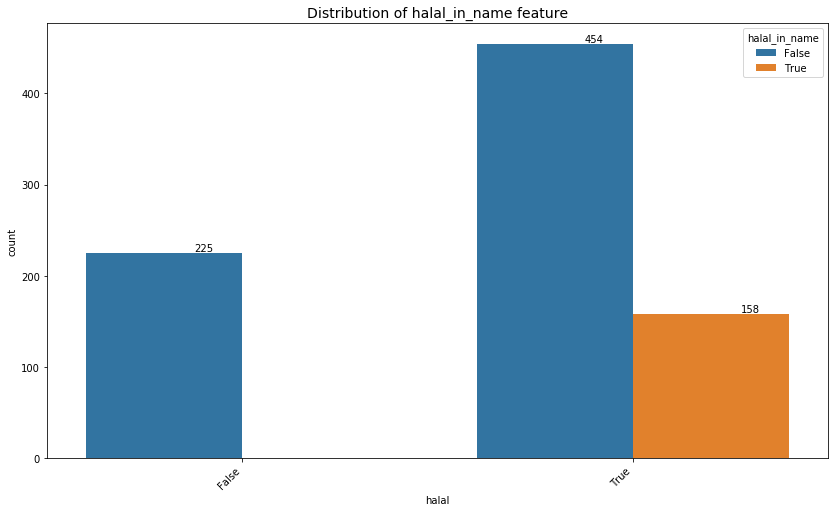

In [66]:
# group reviews per restaurant
grouped_reviews_df = reviews_df.groupby('restaurant_id').agg(lambda x: ' '.join(x)) # combine review text
grouped_reviews_df['review_date'] = grouped_reviews_df['review_date'].apply(lambda x: x.split()) # make dates list
grouped_reviews_df['review_count'] = grouped_reviews_df['review_date'].apply(lambda x: len(x)) # count reviews per restaurnat
grouped_reviews_df.head()

# merge restaurant name 
grouped_reviews_df = grouped_reviews_df.merge(target_df[['platform_id', 'name', 'total_review_count', 'halal']], how='left', left_index=True, right_on='platform_id')

grouped_reviews_df.index = grouped_reviews_df['platform_id']
grouped_reviews_df.drop('platform_id', inplace=True, axis=1)
grouped_reviews_df = grouped_reviews_df.rename(columns={'name': 'restaurant_name', 'review_count' : 'halal_review_count'})

# add boolean column for 'halal' in rest_name
grouped_reviews_df['halal_in_name'] = grouped_reviews_df.apply(lambda row: True if 'halal' in row['restaurant_name'].lower() else False, axis=1)

plt.figure(figsize=(14,8))
g = sns.countplot(x='halal', hue='halal_in_name', data=grouped_reviews_df)
g.set_title('Distribution of halal_in_name feature', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## 2. Percentage of reviews including the word halal out of all reviews

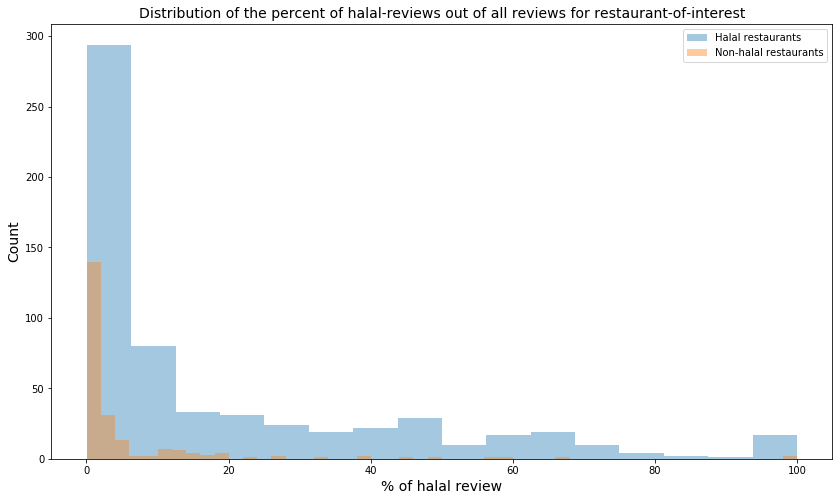

In [91]:
# calculate percentage of halal-containing reviews out of total reviews
grouped_reviews_df['halal_review_percent'] = grouped_reviews_df.apply(lambda row: row['halal_review_count']/row['total_review_count'], axis =1)

# plot distribution for halal vs non-halal restaurants
halal_target = grouped_reviews_df[grouped_reviews_df['halal']]['halal_review_percent']
non_halal_target = grouped_reviews_df[~grouped_reviews_df['halal']]['halal_review_percent']
fig = plt.figure(figsize=(14,8))
g1 = sns.distplot(halal_target*100, kde=False)
g2 = sns.distplot(non_halal_target*100, kde=False)
g1.set_title('Distribution of the percent of halal-reviews out of all reviews for restaurant-of-interest', size=14)
g1.set_xlabel('% of halal review', size=14)
g1.set_ylabel('Count', size=14)
plt.legend(labels=['Halal restaurants','Non-halal restaurants'], prop={'size': 10})
plt.show()

In [84]:
grouped_reviews_df[(grouped_reviews_df['halal_review_percent'] > 0.9) & (~grouped_reviews_df['halal'])]

,review_text,review_date,halal_review_count,restaurant_name,total_review_count,halal,halal_in_name,halal_review_percent
platform_id,,,,,,,,
OLEjsQZtBDLRdiLe19o4fg,"Be careful while eating here, they say everyth...","[3/2/2020, 1/29/2020]",2,Airport Deli,2,False,False,1.0
eoxv_U5MOY8qcSvPTY1HSw,I came uptown to meet 2 friends for a get toge...,"[1/8/2020, 1/21/2020]",2,Chapati Man NY,2,False,False,1.0


- The higher percentage of halal-related reviews in non-halal restaurants is probably related to food carts or restaurants with few reviews to start with and they have comparison to halal-guys or halal street cuisine 

## 3. Spacy nlp to find text patterns
### 3.1. tokenize and match pattern [lemma=be, lower=halal]

In [105]:
# # run nlp of grouped review text and save Doc to dataframe
# nlp = en_core_web_sm.load()
# grouped_reviews_df['doc'] = grouped_reviews_df['review_text'].apply(lambda x: nlp(x))

# initialize matcher
matcher = Matcher(nlp.vocab)

# specify match pattern
pattern = [{'LEMMA': 'be'},{'LOWER': 'halal'}]
matcher.add('be_halal', None, pattern)

# match and print the first few setences
c=10
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    count = len(match)
    grouped_reviews_df.loc[i, 'be_halal_count'] = count
    grouped_reviews_df.loc[i, 'be_halal'] = True if count>0 else False
    if c>0:
        for match_id, start, end in match:
            print(doc[start:end].sent)
        c -= 1

Love this place and love that it's halal.
and they happen to be halal!
Love that it's halal and delicious.
The entire menu is halal and although they do not serve alcohol, you are welcome bring your own.
The meat are halal.
I have asked them verbally three times if their meat is halal
, everything is halal.
both times was told again yes - everything is halal.


If you only have a partially halal menu, then do not mislead customers by saying everything you serve is halal.
Oh and if you're a Halal foodie then you're in luck because this place is Halal.


A definite plus being halal for the Muslim community.


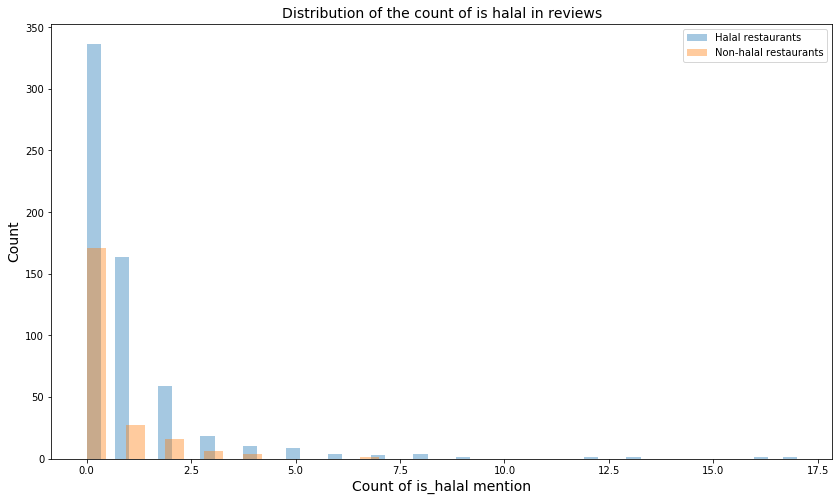

In [108]:
# plot distribution of number of matches found for halal vs. non-halal restaurants
halal_target = grouped_reviews_df[grouped_reviews_df['halal']]['be_halal_count']
non_halal_target = grouped_reviews_df[~grouped_reviews_df['halal']]['be_halal_count']
fig = plt.figure(figsize=(14,8))
g1 = sns.distplot(halal_target, kde=False)
g2 = sns.distplot(non_halal_target, kde=False)
g1.set_title('Distribution of the count of is halal in reviews', size=14)
g1.set_xlabel('Count of is_halal mention', size=14)
g1.set_ylabel('Count', size=14)
plt.legend(labels=['Halal restaurants','Non-halal restaurants'], prop={'size': 10})
plt.show()

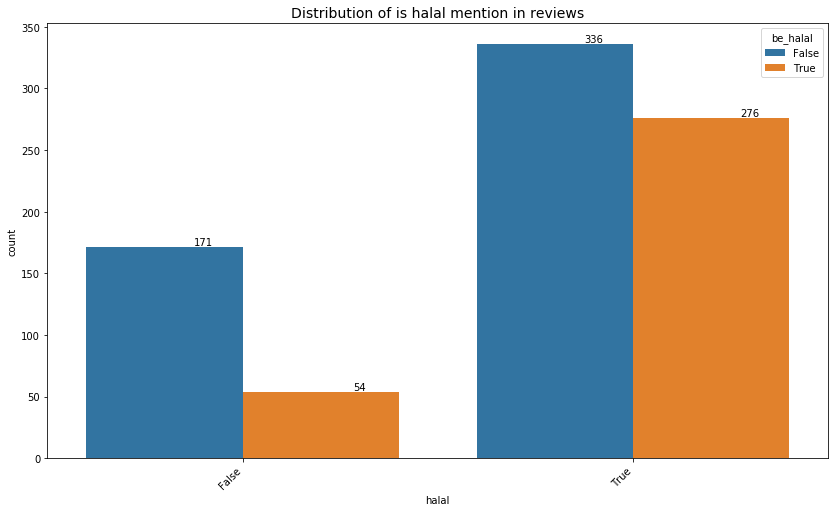

In [110]:
# barplot of categorical be_halal
plt.figure(figsize=(14,8))
g = sns.countplot(x='halal', hue='be_halal', data=grouped_reviews_df)
g.set_title('Distribution of is halal mention in reviews', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

### 3.2. Match pattern 'halal guys/ truck' and count how many it occurs out of all the mentiones of halal

In [111]:
# initialize matcher
matcher = Matcher(nlp.vocab)

# find all incidences of halal
pattern = [{'LOWER': 'halal'}]
matcher.add('halal', None, pattern)
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    grouped_reviews_df.loc[i, 'halal_match_count'] = len(match)

# reinitialize matcher
matcher = Matcher(nlp.vocab)

# match 'halal guys'
pattern1 = [{'LOWER': 'halal'}, {'LOWER': 'guys'}]
pattern2 = [{'LOWER': 'halal'}, {'LOWER': 'truck'}]
pattern3 = [{'LOWER': 'halal'}, {'LOWER': 'trucks'}]
matcher.add('halal_guys', None, pattern1)
matcher.add('halal_guys', None, pattern2)
matcher.add('halal_guys', None, pattern3)

# match and print the first few setences
c=10
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    grouped_reviews_df.loc[i, 'halal_guys_count'] = len(match)
    if c>0:
        for match_id, start, end in match:
            print(doc[start:end].sent)
        c -= 1
        
grouped_reviews_df['halal_guys_percent'] = grouped_reviews_df.apply(lambda row: row['halal_guys_count'] / row['halal_match_count'], axis=1)

This is he halal truck that made me fall in love with halal trucks!
This is he halal truck that made me fall in love with halal trucks!
Quick, better than halal guys, and have a magical green sauce.
The halal guys at midtown are only good for quantity, and considering how they charge you $7, I think the price to quantity ratio is about the same.  
This Starbucks is right in front of Halal Guys
This starbucks was conveniently located right next to Halal Guys, and so we decided to stop by to get some drinks after eating.


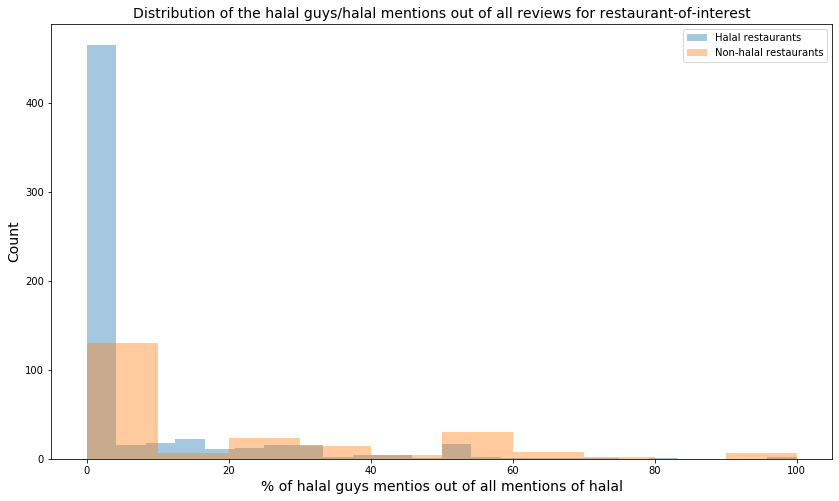

In [112]:
# plot distribution of 'halal guys' mention out of all 'halal' mentions for halal vs. non-halal restaurants
halal_target = grouped_reviews_df[grouped_reviews_df['halal']]['halal_guys_percent']
non_halal_target = grouped_reviews_df[~grouped_reviews_df['halal']]['halal_guys_percent']
fig = plt.figure(figsize=(14,8))
g1 = sns.distplot(halal_target*100, kde=False)
g2 = sns.distplot(non_halal_target*100, kde=False)
g1.set_title('Distribution of the halal guys/halal mentions out of all reviews for restaurant-of-interest', size=14)
g1.set_xlabel('% of halal guys mentios out of all mentions of halal', size=14)
g1.set_ylabel('Count', size=14)
plt.legend(labels=['Halal restaurants','Non-halal restaurants'], prop={'size': 10})
plt.show()

### 3.3. mention of halal chicken vs. halal burger

In [114]:
# initialize matcher
matcher = Matcher(nlp.vocab)

# contains halal chicken
pattern1 = [{'LOWER': 'halal'}, {'LOWER': 'chicken'}]
matcher.add('chicken', None, pattern1)
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    grouped_reviews_df.loc[i, 'chicken'] = True if len(match) else False

 # initialize matcher
matcher = Matcher(nlp.vocab)

# contains halal burger
pattern2 = [{'LOWER': 'halal'}, {'LOWER': 'burger'}]
matcher.add('burger', None, pattern2)
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    grouped_reviews_df.loc[i, 'burger'] = True if len(match) else False

# initialize matcher
matcher = Matcher(nlp.vocab)

# contains CreekStone # a company with halal certified steaks and beef but these products are often cooked on the
# grill alongside non-halal ingerdients
pattern2 = [{'LOWER': 'creekstone'}]
matcher.add('creekstone', None, pattern2)
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    grouped_reviews_df.loc[i, 'creekstone'] = True if len(match) else False

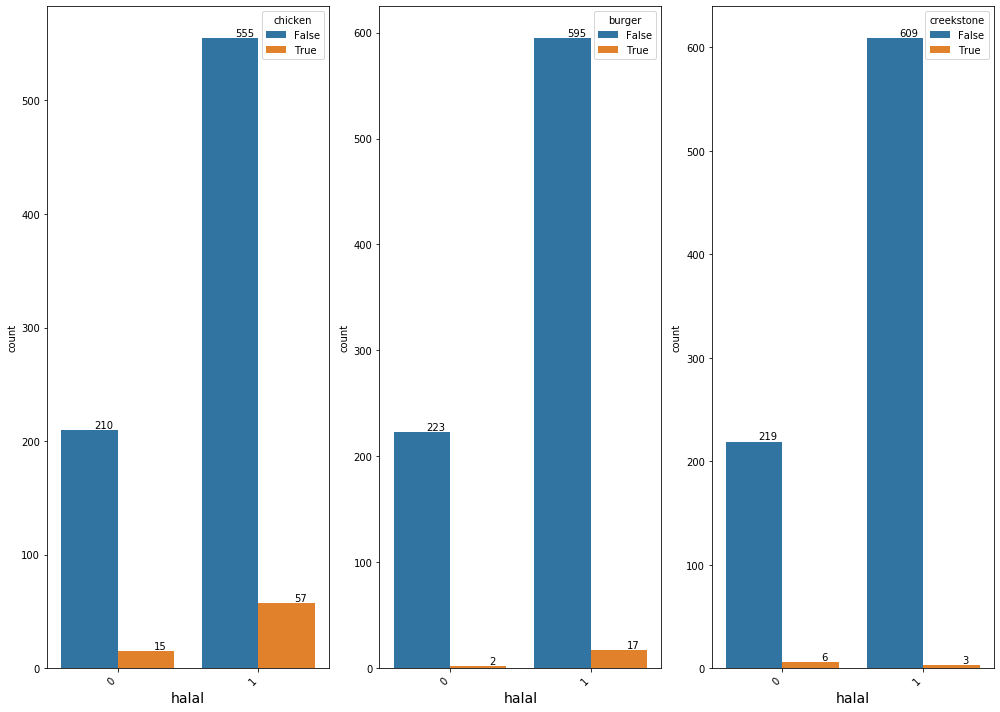

In [126]:
# barplot of chicken, burger and CreekStone
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(14,10))

columns = ['chicken', 'burger', 'creekstone']
for col, ax in zip(columns, axes.flat):
    g = sns.countplot(x='halal', hue=col, data=grouped_reviews_df, ax=ax)
    g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    for p in g.patches:
        g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom', color= 'black')
    ax.set_xlabel('halal', size=14)
    ax.set_xticklabels(labels=ax.get_xticks(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

- When combined with halal chicken and burger do not provide significant information. 
- Consider trying more combinations with 'chicken', such as 'chicken over rice' or chicken as DEP=compound noun.
- CreekStone has 2:1 chance of being mentioned in non-halal vs. halal restaurant.

### 3.4. Mention of '100% halal'

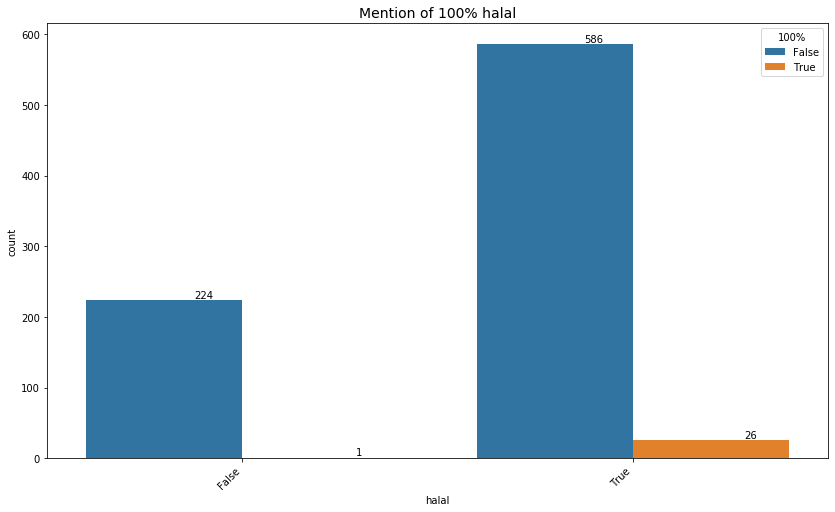

In [127]:
# initialize matcher
matcher = Matcher(nlp.vocab)

# contains halal chicken
pattern3 = [{'IS_DIGIT': True, 'LOWER': '100'},
           {'IS_PUNCT': True},
           {'LOWER': 'halal'}]
matcher.add('100%', None, pattern3)
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    grouped_reviews_df.loc[i, '100%'] = True if len(match) else False

plt.figure(figsize=(14,8))
g = sns.countplot(x='halal', hue='100%', data=grouped_reviews_df)
g.set_title('Mention of 100% halal', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

### 3.5. Mention of non-halal terms